# Tutorial 3: K-Means and Time Domain Reduction

A good tool to reduce computation time of GenX is to use <a href="https://genxproject.github.io/GenX/dev/methods/#Time-Domain-Reduction-(TDR)" target="_blank">Time Domain Reduction (TDR)</a>. Time Domain Reduction is a method that selects a smaller set of time steps from the data in a way that reduces computation time while still capturing the main information of the model. In this tutorial, we go over how TDR works in GenX and how it uses K-means clustering to choose the optimal time steps.

### Time Domain Reduction

To see how Time Domain Reduction works, let's look at the `Load_data` in `Example_Systems_Tutorials/SmallNewEngland/OneZone`:

In [1]:
# First, load all packages needed
using DataFrames
using CSV
using VegaLite
using YAML
using PlotlyJS
using Plots
using Clustering
using ScikitLearn
@sk_import datasets: (make_blobs)

WebIO._IJuliaInit()

[ Info: mkl not found, proceeding to installing non-mkl versions of sci-kit learn via Conda
[ Info: Running `conda install -y -c conda-forge 'scikit-learn>=1.2,<1.3'` in root environment


Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0




PyObject <function make_blobs at 0x2860f96c0>

In [2]:
loads =  CSV.read("Example_Systems_Tutorials/SmallNewEngland/OneZone/Load_data.csv",DataFrame,missingstring="NA")

8760×9 DataFrame
  Row │ Voll     Demand_Segment  Cost_of_Demand_Curtailment_per_MW  Max_Demand ⋯
      │ String7  String3         String3                            String3    ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 50000    1               1                                  1          ⋯
    2 │
    3 │
    4 │
    5 │                                                                        ⋯
    6 │
    7 │
    8 │
    9 │                                                                        ⋯
   10 │
   11 │
  ⋮   │    ⋮           ⋮                         ⋮                             ⋱
 8751 │
 8752 │                                                                        ⋯
 8753 │
 8754 │
 8755 │
 8756 │                                                                        ⋯
 8757 │
 8758 │
 8759 │
 8760 │                                                                        ⋯
                                                 6 columns and 8739 rows omitted

The columns to note in this file are `Rep_Periods`, `TimeSteps_Per_Rep_Period`, `Time_Index`, and `Load_MW_z1`. This file shows the number of time steps used in GenX before applying TDR, i.e. every hour in a year, totaling 8,760 hours. This means that there is only one representative period, as seen in `Rep_Periods`.

TDR performs a "reduction" into a specified number of "representative periods", paring down the input data into a smaller set. The representative periods are then used in the GenX algorithm in place of the entire input data to reduce computation time. The TDR algorithm selects the representative periods to be the set of data whose results in GenX best match the results of the entire input data. To do this, TDR using k-means clustering, described in the next section.

When TDR is used, the file `time_domain_reduction_settings.yml` is called with a variety of specified settings, shown below:

In [3]:
time_domain_reduction_settings = YAML.load(open("Example_Systems_Tutorials/SmallNewEngland/OneZone/Settings/time_domain_reduction_settings.yml"))

Dict{Any, Any} with 15 entries:
  "IterativelyAddPeriods" => 1
  "ExtremePeriods"        => Dict{Any, Any}("Wind"=>Dict{Any, Any}("System"=>Di…
  "UseExtremePeriods"     => 1
  "MinPeriods"            => 8
  "MaxPeriods"            => 11
  "LoadWeight"            => 1
  "ClusterFuelPrices"     => 1
  "nReps"                 => 100
  "MultiStageConcatenate" => 0
  "Threshold"             => 0.05
  "TimestepsPerRepPeriod" => 168
  "IterateMethod"         => "cluster"
  "ScalingMethod"         => "S"
  "ClusterMethod"         => "kmeans"
  "WeightTotal"           => 8760

Important here to note are `MinPeriods` and `MaxPeriods`. As TDR is performed, it is required to keep the number of representative periods to be between the min and max specified in the settings. This is to ensure that computation time is actually decreased and that the k-means algorithm doesn't just form one large cluster of all points. Additionally, `TimestepsPerRepPeriod` is set to 168, the number of hours in a week (`WeightTotal` includes all 8,760 timesteps, the number of hours in a year.) By specifying the number of timesteps in each representative period to be a week, we form 52 clusters from which the algorithm will choose 8-11.

For descriptions of all settings, see <a href="https://genxproject.github.io/GenX/dev/methods/#GenX.cluster_inputs" target="_blank">GenX.cluster_inputs</a> in the documentation.

Now back to pre-TDR. Below shows the load per timestep in megawatts for the entire dataset, i.e. with only one representative period of 8760 hours:

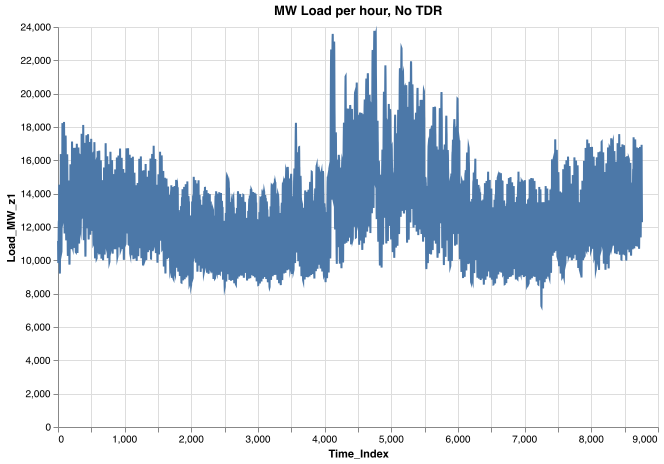

In [4]:
loads |>
@vlplot(:line, 
    x=:Time_Index, y=:Load_MW_z1, title="MW Load per hour, No TDR",
    width=600,height=400,linewidth=.01)

As in Tutorial 1, we can open the `genx_settings.yml` file for `SmallNewEngland/OneZone` to see how `TimeDomainReduction` is set. If it's set to 1, this means TDR is being used.

In [5]:
genx_settings_SNE = YAML.load(open("Example_Systems_Tutorials/SmallNewEngland/OneZone/Settings/genx_settings.yml"))

Dict{Any, Any} with 21 entries:
  "NetworkExpansion"                        => 0
  "TimeDomainReductionFolder"               => "TDR_Results"
  "ModelingToGenerateAlternativeIterations" => 3
  "ParameterScale"                          => 1
  "EnergyShareRequirement"                  => 1
  "PrintModel"                              => 0
  "TimeDomainReduction"                     => 1
  "Trans_Loss_Segments"                     => 1
  "CapacityReserveMargin"                   => 1
  "ModelingtoGenerateAlternativeSlack"      => 0.1
  "Solver"                                  => "HiGHS"
  "MethodofMorris"                          => 0
  "Reserves"                                => 0
  "StorageLosses"                           => 1
  "OverwriteResults"                        => 0
  "UCommit"                                 => 2
  "ModelingToGenerateAlternatives"          => 0
  "MaxCapReq"                               => 1
  "MinCapReq"                               => 1
  "CO2Cap"       

To visualize how TDR decreases computation time, let's start by running `SmallNewEngland/OneZone` without TDR. In the third section of this tutorial, we'll run the example again using TDR.

To run GenX without TDR, we start by editing the settings to set `TimeDomainReduction` to 0:

In [6]:
genx_settings_SNE["TimeDomainReduction"] = 0
genx_settings_SNE ## Output settings

Dict{Any, Any} with 21 entries:
  "NetworkExpansion"                        => 0
  "TimeDomainReductionFolder"               => "TDR_Results"
  "ModelingToGenerateAlternativeIterations" => 3
  "ParameterScale"                          => 1
  "EnergyShareRequirement"                  => 1
  "PrintModel"                              => 0
  "TimeDomainReduction"                     => 0
  "Trans_Loss_Segments"                     => 1
  "CapacityReserveMargin"                   => 1
  "ModelingtoGenerateAlternativeSlack"      => 0.1
  "Solver"                                  => "HiGHS"
  "MethodofMorris"                          => 0
  "Reserves"                                => 0
  "StorageLosses"                           => 1
  "OverwriteResults"                        => 0
  "UCommit"                                 => 2
  "ModelingToGenerateAlternatives"          => 0
  "MaxCapReq"                               => 1
  "MinCapReq"                               => 1
  "CO2Cap"       

Then we write the edited settings to the file path:

In [7]:
YAML.write_file("Example_Systems_Tutorials/SmallNewEngland/OneZone/Settings/genx_settings.yml", genx_settings_SNE)

In [8]:
genx_settings_SNE

Dict{Any, Any} with 21 entries:
  "NetworkExpansion"                        => 0
  "TimeDomainReductionFolder"               => "TDR_Results"
  "ModelingToGenerateAlternativeIterations" => 3
  "ParameterScale"                          => 1
  "EnergyShareRequirement"                  => 1
  "PrintModel"                              => 0
  "TimeDomainReduction"                     => 0
  "Trans_Loss_Segments"                     => 1
  "CapacityReserveMargin"                   => 1
  "ModelingtoGenerateAlternativeSlack"      => 0.1
  "Solver"                                  => "HiGHS"
  "MethodofMorris"                          => 0
  "Reserves"                                => 0
  "StorageLosses"                           => 1
  "OverwriteResults"                        => 0
  "UCommit"                                 => 2
  "ModelingToGenerateAlternatives"          => 0
  "MaxCapReq"                               => 1
  "MinCapReq"                               => 1
  "CO2Cap"       

And run it using `include`. (Note: this process will take a few minutes):

In [9]:
@time include("Example_Systems_Tutorials/SmallNewEngland/OneZone/Run.jl")

Configuring Settings
Configuring Solver
Loading Inputs
Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
Capacity_reserve_margin.csv Successfully Read!
Minimum_capacity_requirement.csv Successfully Read!
Maximum_capacity_requirement.csv Successfully Read!
Energy_share_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From /Users/mayamutic/Desktop/GenX/Tutorials/Example_Systems_Tutorials/SmallNewEngland/OneZone
Generating the Optimization Model
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Emissions Module (for CO2 Policy modularization
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal 

This took a little while to run, and would take even longer for larger systems. Let's see how we can get the run time down using Time Domain Reduction. The next sections go over how K-means clustering is used to perform TDR, and how to interpret the resulting files in GenX.

### K-means clustering

Let's go over how TDR works. To perform TDR, GenX uses __K-means clustering__. K-means is an optimization method that clusters data into several groups based on their proximity to "centers" determined by the algorithm. 

K-means finds a set number of groups such that the variance between the distance of each point in the group to the mean of the group is minimized. 

$$
\begin{align*}
\mathop{\arg \min}\limits_{\mathbf{S}} & \sum_{i = 1}^k \sum_{x \in S_i} ||x - \mu_i||^2 \\
\end{align*}
$$

Where $\mathbf{S} = \{S_1, ... , S_k\}$ are the clusters, with $x$ denoting the elements of the clusters, and $\mu_i$ the mean of each cluster, i.e. the mean of the distances from each point to the center of the cluster. By taking the argmin over $\mathbf{S}$, the points $x$ are clustered into groups where their distance to the center is the smallest. For more information on how k-means works, see the  <a href="https://en.wikipedia.org/wiki/K-means_clustering" target="_blank">Wikipedia</a>. 

GenX uses the package `Clustering.jl`, with documentation <a href="https://juliastats.org/Clustering.jl/dev/kmeans.html#K-means" target="_blank">here</a>. As an example, using the package `ScikitLearn.jl`, let's generate data that can cluster easily.

In [10]:
centers = 5
X, y = make_blobs(n_samples=50,centers=centers); # From scikit-learn
b = DataFrame(X,:auto)

50×2 DataFrame
 Row │ x1         x2        
     │ Float64    Float64   
─────┼──────────────────────
   1 │  1.359      1.28958
   2 │ -7.45013   -9.48353
   3 │ -2.48457   -2.34627
   4 │  2.71364    0.459631
   5 │ -2.64326   -6.96089
   6 │ 10.1227     1.181
   7 │ -6.82656   -8.21637
   8 │ -6.13951   -9.17984
   9 │  9.51929    1.16504
  10 │  7.2222     2.35907
  11 │  0.976875   1.32474
  ⋮  │     ⋮          ⋮
  41 │  6.94076    1.30133
  42 │ -1.11645    0.52441
  43 │  9.71308    0.996823
  44 │  1.30061    1.3798
  45 │ -2.20608   -4.79804
  46 │ -5.9547     6.90973
  47 │ -5.66264    7.94054
  48 │ -1.20211   -5.15779
  49 │  7.44552   -0.541025
  50 │  1.51788   -0.570418
             29 rows omitted

Note that clustering works for data without obvious groupings, but using blobs as an example makes k-means easier to visualize.

In [11]:
plotly()
Plots.scatter(b[!,"x1"],b[!,"x2"],legend=false,title="Before K-means Clustering")

Now we use the function `kmeans`, which is also used in `src/time_domain_reduction` in GenX.

In [12]:
R = kmeans(transpose(Matrix(b)),centers);

`kmeans` returns three outputs: assignments, centers, and counts. Assignments shows to which cluster each points belongs, centers shows where the center coordinates of each cluster are, and counts shows how many points belong to each cluster.

In [13]:
println("Assignments = ",R.assignments)
println("")
println("Counts = ",R.counts)
println("")
println("Centers:")
R.centers

Assignments = [5, 2, 3, 5, 3, 4, 2, 2, 4, 4, 5, 4, 5, 2, 2, 3, 1, 2, 3, 2, 1, 3, 4, 2, 3, 1, 3, 5, 2, 1, 4, 5, 1, 2, 1, 4, 1, 3, 5, 1, 4, 5, 4, 5, 3, 1, 1, 3, 4, 5]

Counts = [10, 10, 10, 10, 10]

Centers:


2×5 Matrix{Float64}:
 -5.95683  -7.27394  -1.87509  8.67843   0.879172
  7.85846  -9.1421   -5.1897   0.745797  0.843052

In [14]:
plotly()
Plots.scatter(b[!,"x1"],b[!,"x2"],legend=false,marker_z=R.assignments,c=:lightrainbow,title="After K-means Clustering")

In GenX, the representative periods are the centers of the clusters, each representing one week of the year. In the above example that would mean there are 52 data points gathered into 11 clusters (to see this for yourself, change `make_blobs` to have 52 data points and 11 clusters. Note that having 11 clusters will cause the colors of some clusters to be very similar.)

### Results of Time Domain Reduction

To visualize the results of TDR, we'll set TDR = 1 back in the `genx_settings.yml` file in `Example_Systems_Tutorials/SmallNewEngland/OneZone/`:

In [15]:
genx_settings_SNE["TimeDomainReduction"] = 1;

In [16]:
genx_settings_SNE

Dict{Any, Any} with 21 entries:
  "NetworkExpansion"                        => 0
  "TimeDomainReductionFolder"               => "TDR_Results"
  "ModelingToGenerateAlternativeIterations" => 3
  "ParameterScale"                          => 1
  "EnergyShareRequirement"                  => 1
  "PrintModel"                              => 0
  "TimeDomainReduction"                     => 1
  "Trans_Loss_Segments"                     => 1
  "CapacityReserveMargin"                   => 1
  "ModelingtoGenerateAlternativeSlack"      => 0.1
  "Solver"                                  => "HiGHS"
  "MethodofMorris"                          => 0
  "Reserves"                                => 0
  "StorageLosses"                           => 1
  "OverwriteResults"                        => 0
  "UCommit"                                 => 2
  "ModelingToGenerateAlternatives"          => 0
  "MaxCapReq"                               => 1
  "MinCapReq"                               => 1
  "CO2Cap"       

In [17]:
YAML.write_file("Example_Systems_Tutorials/SmallNewEngland/OneZone/Settings/genx_settings.yml", genx_settings_SNE)

And run GenX again with TDR:

In [18]:
@time include("Example_Systems_Tutorials/SmallNewEngland/OneZone/Run.jl")

Configuring Settings
Clustering Time Series Data (Grouped)...
Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
Capacity_reserve_margin.csv Successfully Read!
Minimum_capacity_requirement.csv Successfully Read!
Maximum_capacity_requirement.csv Successfully Read!
Energy_share_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From /Users/mayamutic/Desktop/GenX/Tutorials/Example_Systems_Tutorials/SmallNewEngland/OneZone
Configuring Solver
Loading Inputs
Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
Capacity_reserve_margin.csv Successfully Read!
Minimum_capacity_requirement.csv Successful

Csv files with the results of TDR are generated automatically in a folder called `TDR_results` found within the same folder containing the input csv files, in this case `Example_Systems_Tutorials/SmallNewEngland/OneZone`. The csv files in this folder show the files used in `Run.jl` that have been pared down from the initial input files.

As an example, consider the input file `Fuels_data.csv`:

In [19]:
Fuels_original = CSV.read("Example_Systems_Tutorials/SmallNewEngland/OneZone/Fuels_data.csv",DataFrame,missingstring="NA")


8761×3 DataFrame
  Row │ Time_Index  NG       None  
      │ Int64       Float64  Int64 
──────┼────────────────────────────
    1 │          0  0.05306      0
    2 │          1  5.28         0
    3 │          2  5.28         0
    4 │          3  5.28         0
    5 │          4  5.28         0
    6 │          5  5.28         0
    7 │          6  5.28         0
    8 │          7  5.28         0
    9 │          8  5.28         0
   10 │          9  5.28         0
   11 │         10  5.28         0
  ⋮   │     ⋮          ⋮       ⋮
 8752 │       8751  4.28         0
 8753 │       8752  4.28         0
 8754 │       8753  4.28         0
 8755 │       8754  4.28         0
 8756 │       8755  4.28         0
 8757 │       8756  4.28         0
 8758 │       8757  4.28         0
 8759 │       8758  4.28         0
 8760 │       8759  4.28         0
 8761 │       8760  4.28         0
                  8740 rows omitted

Compared to `TDR_Results/Fuels_data.csv`:

In [20]:
Fuels_TDR = CSV.read("Example_Systems_Tutorials/SmallNewEngland/OneZone/TDR_Results/Fuels_data.csv",DataFrame,missingstring="NA")

1849×3 DataFrame
  Row │ Time_Index  NG       None    
      │ Int64       Float64  Float64 
──────┼──────────────────────────────
    1 │          0  0.05306      0.0
    2 │          1  5.28         0.0
    3 │          2  5.28         0.0
    4 │          3  5.28         0.0
    5 │          4  5.28         0.0
    6 │          5  5.28         0.0
    7 │          6  5.28         0.0
    8 │          7  5.28         0.0
    9 │          8  5.28         0.0
   10 │          9  5.28         0.0
   11 │         10  5.28         0.0
  ⋮   │     ⋮          ⋮        ⋮
 1840 │       1839  4.28         0.0
 1841 │       1840  4.28         0.0
 1842 │       1841  4.28         0.0
 1843 │       1842  4.28         0.0
 1844 │       1843  4.28         0.0
 1845 │       1844  4.28         0.0
 1846 │       1845  4.28         0.0
 1847 │       1846  4.28         0.0
 1848 │       1847  4.28         0.0
 1849 │       1848  4.28         0.0
                    1828 rows omitted

As you can see, the original has all 8,760 hours, while the TDR version only has 1,848 hours.

In [21]:
loads_TDR = CSV.read("Example_Systems_Tutorials/SmallNewEngland/OneZone/TDR_Results/Load_data.csv",DataFrame,missingstring="NA")

1848×9 DataFrame
  Row │ Voll     Demand_Segment  Cost_of_Demand_Curtailment_per_MW  Max_Demand ⋯
      │ String7  String3         String3                            String3    ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 50000    1               1                                  1          ⋯
    2 │
    3 │
    4 │
    5 │                                                                        ⋯
    6 │
    7 │
    8 │
    9 │                                                                        ⋯
   10 │
   11 │
  ⋮   │    ⋮           ⋮                         ⋮                             ⋱
 1839 │
 1840 │                                                                        ⋯
 1841 │
 1842 │
 1843 │
 1844 │                                                                        ⋯
 1845 │
 1846 │
 1847 │
 1848 │                                                                        ⋯
                                                 6 columns and 1827 rows omitted

The 1,848 hours are divided into 11 sections of 168 hours, with each section representing one week of the original data.  The number of hours per representative period is set in `time_domain_reduction_settings.yml`. Also specified in the file are the minimum and maximum number of clusters we would like to have (in this case 8 and 11). The k-means algorithm will then select the number of clusters that should be sufficient to capture the GenX model in fewer time steps (in this case 11).

Below, we create arrays out of the representative weeks and plot them on the same plot used in the beginning of this tutorial. The file `Period_map` shows which periods (weeks) are used in TDR and which time step corresponds to each period:

In [23]:

Period_map = CSV.read("Example_Systems_Tutorials/SmallNewEngland/OneZone/TDR_Results/Period_map.csv",DataFrame,missingstring="NA")

52×3 DataFrame
 Row │ Period_Index  Rep_Period  Rep_Period_Index 
     │ Int64         Int64       Int64            
─────┼────────────────────────────────────────────
   1 │            1           1                 1
   2 │            2           1                 1
   3 │            3           1                 1
   4 │            4           1                 1
   5 │            5           7                 2
   6 │            6           7                 2
   7 │            7           7                 2
   8 │            8           7                 2
   9 │            9           7                 2
  10 │           10          15                 3
  11 │           11           7                 2
  ⋮  │      ⋮            ⋮              ⋮
  43 │           43          24                 4
  44 │           44          24                 4
  45 │           45          45                 7
  46 │           46          46                 8
  47 │           47          46                 8
  48 │           48          48                 9
  49 │           49          50                10
  50 │           50          50                10
  51 │           51          51                11
  52 │           52          50                10
                                   31 rows omitted

In [24]:
# Find array of unique representative periods
rep_periods = unique(Period_map[!,"Rep_Period"])

11-element Vector{Int64}:
  1
  7
 15
 46
 24
 28
 29
 45
 48
 50
 51

In [25]:
# Create an array of the time steps and MW values of each representative period
weeks = []
for i in rep_periods
    week_temp = [repeat([i],168) loads[(168*i-167):168*i,8] loads[(168*i-167):168*i,9]]
    weeks = [weeks; week_temp]
end
weeks

1848×3 Matrix{Any}:
  1     1  11162
  1     2  10556
  1     3  10105
  1     4   9878
  1     5   9843
  1     6  10017
  1     7  10390
  1     8  10727
  1     9  11298
  1    10  11859
  1    11  12196
  1    12  12321
  1    13  12381
  ⋮        
 51  8557  13911
 51  8558  13818
 51  8559  13710
 51  8560  13796
 51  8561  15038
 51  8562  16088
 51  8563  16076
 51  8564  15782
 51  8565  15392
 51  8566  14663
 51  8567  13620
 51  8568  12388

In [26]:
# Combine with Total (pre TDR)
loads_plot = [repeat(["Total"],8760) loads[!,end-1] loads[!,end]];

In [27]:
# Add column names and convert column type
loads_with_TDR = [loads_plot; weeks]
loads_with_TDR = DataFrame(loads_with_TDR ,["Week","hour", "MW"])
loads_with_TDR[!,:hour] = convert.(Int64,loads_with_TDR[!,:hour]);
loads_with_TDR[!,:MW] = convert.(Float64,loads_with_TDR[!,:MW]);

Here's the same plot from before but with representative weeks highlighted:

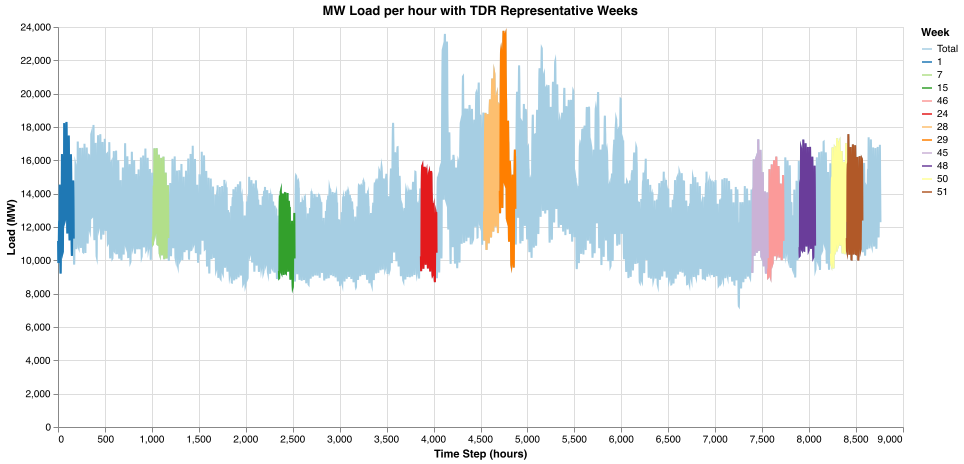

In [28]:
loads_with_TDR  |>
@vlplot(mark={:line},
    x={:hour,title="Time Step (hours)",labels="Week:n"}, y={:MW,title="Load (MW)"},
    color={"Week:n", scale={scheme="paired"},sort="decsending"}, title="MW Load per hour with TDR Representative Weeks",
    width=845,height=400)

The range of 8-11 representative periods was chosen by the developers because it was deemed to be the smallest set that still matches the optimal value of the data well. The next section goes over how the optimal values of the data change as the number of representative periods changes.

In [ ]:
## Maybe: explain why more centers in winter

### Objective Values and Representative Periods

Each time `Run.jl` is run, a `Results` folder is produced. This folder contains numerous .csv files with output variable from the GenX model. For more information on all outputs, see the documentation <a href="https://genxproject.github.io/GenX/dev/data_documentation/#Outputs" target="_blank">here</a>.

This section focuses on the __objective value__ of the model. In optimization problems, the objective value is the main value minimized or maximized within the constraints of the model, according to the __objective function__ specified in the problem formulation. In the case of GenX, the objective function is the total annual electricity system cost. A detailed description of the optimization problem is  <a href="https://genxproject.github.io/GenX/dev/objective_function/" target="_blank">here</a> in the documentation. 

For the purpose of this tutorial, we focus on the objective value as a way to evaluate how well the representative periods actually "represent" the entire model. To see how well the objective value of representative periods aligns with that of the total period, we can run `SmallNewEngland/OneZone` with a variety of minimum and maximum total periods.

Each time `Run.jl` is run, a new results folder appears in the model folder. These folders are not overwritten. So far, we've run the model twice, so we should have two results folders, `Results` and `Results_1` in the `OneZone` folder, but you may have more if you've run the model more. To ensure that the following code works, we'll delete any Results folders beyond the original `Results`.

In [45]:
folders = cd(readdir,"Example_Systems_Tutorials/SmallNewEngland/OneZone")

24-element Vector{String}:
 ".DS_Store"
 "CO2_cap.csv"
 "Capacity_reserve_margin.csv"
 "Energy_share_requirement.csv"
 "Fuels_data.csv"
 "Generators_data.csv"
 "Generators_variability.csv"
 "Load_data.csv"
 "Maximum_capacity_requirement.csv"
 "Minimum_capacity_requirement.csv"
 "Network.csv"
 "README.md"
 "Reserves.csv"
 "Results"
 "Results_1"
 "Results_2"
 "Results_3"
 "Results_4"
 "Results_5"
 "Results_6"
 "Results_7"
 "Run.jl"
 "Settings"
 "TDR_Results"

In [46]:
for folder in folders
    if length(folder) >= 8 && folder[1:8] == "Results_"
        rm("Example_Systems_Tutorials/SmallNewEngland/OneZone/" * folder,recursive=true) 
    end
end

In [47]:
cd(readdir,"Example_Systems_Tutorials/SmallNewEngland/OneZone") ## Make sure they were deleted

17-element Vector{String}:
 ".DS_Store"
 "CO2_cap.csv"
 "Capacity_reserve_margin.csv"
 "Energy_share_requirement.csv"
 "Fuels_data.csv"
 "Generators_data.csv"
 "Generators_variability.csv"
 "Load_data.csv"
 "Maximum_capacity_requirement.csv"
 "Minimum_capacity_requirement.csv"
 "Network.csv"
 "README.md"
 "Reserves.csv"
 "Results"
 "Run.jl"
 "Settings"
 "TDR_Results"

Now, we're going to change the min and max periods in the TDR settings. As a reminder, here are the time domain reduction settings we've been using:

In [32]:
time_domain_reduction_settings

Dict{Any, Any} with 15 entries:
  "IterativelyAddPeriods" => 1
  "ExtremePeriods"        => Dict{Any, Any}("Wind"=>Dict{Any, Any}("System"=>Di…
  "UseExtremePeriods"     => 1
  "MinPeriods"            => 8
  "MaxPeriods"            => 11
  "LoadWeight"            => 1
  "ClusterFuelPrices"     => 1
  "nReps"                 => 100
  "MultiStageConcatenate" => 0
  "Threshold"             => 0.05
  "TimestepsPerRepPeriod" => 168
  "IterateMethod"         => "cluster"
  "ScalingMethod"         => "S"
  "ClusterMethod"         => "kmeans"
  "WeightTotal"           => 8760

To demonstrate how the objective value changes as the number of representative periods does, we'll run GenX ten times, each with a different number of periods, and plot the objective values.

In [33]:
# Change MinPeriods and Max Periods, run `Run.jl`
# For simplicity, keep min and max periods the same
rep_periods = [4, 8, 12, 24, 36, 48]

for i in range(1,6)
    println(" ")
    println("----------------------------------------------------")
    println("Iteration ",i)
    println("Periods = ",rep_periods[i])
    println("----------------------------------------------------")
    time_domain_reduction_settings["MinPeriods"] = rep_periods[i]
    time_domain_reduction_settings["MaxPeriods"] = rep_periods[i]
    if "TDR_Results" in cd(readdir,"Example_Systems_Tutorials/SmallNewEngland/OneZone")
        rm("Example_Systems_Tutorials/SmallNewEngland/OneZone/TDR_results", recursive=true) 
    end
    println(" ")
    YAML.write_file("Example_Systems_Tutorials/SmallNewEngland/OneZone/Settings/time_domain_reduction_settings.yml", time_domain_reduction_settings)
    @time include("Example_Systems_Tutorials/SmallNewEngland/OneZone/Run.jl");
end

    

 
----------------------------------------------------
Iteration 1
Periods = 4
----------------------------------------------------
 
Configuring Settings
Clustering Time Series Data (Grouped)...
Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
Capacity_reserve_margin.csv Successfully Read!
Minimum_capacity_requirement.csv Successfully Read!
Maximum_capacity_requirement.csv Successfully Read!
Energy_share_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From /Users/mayamutic/Desktop/GenX/Tutorials/Example_Systems_Tutorials/SmallNewEngland/OneZone
Configuring Solver
Loading Inputs
Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.c

Configuring Solver
Loading Inputs
Reading Input CSV Files
Network.csv Successfully Read!
Load_data.csv Successfully Read!
Fuels_data.csv Successfully Read!
Generators_data.csv Successfully Read!
Generators_variability.csv Successfully Read!
Validating time basis
Capacity_reserve_margin.csv Successfully Read!
Minimum_capacity_requirement.csv Successfully Read!
Maximum_capacity_requirement.csv Successfully Read!
Energy_share_requirement.csv Successfully Read!
CO2_cap.csv Successfully Read!
CSV Files Successfully Read In From /Users/mayamutic/Desktop/GenX/Tutorials/Example_Systems_Tutorials/SmallNewEngland/OneZone
Generating the Optimization Model
Discharge Module
Non-served Energy Module
Investment Discharge Module
Unit Commitment Module
Emissions Module (for CO2 Policy modularization
Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Res

Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
C02 Policies Module
Energy Share Requirement Policies Module
Capacity Reserve Margin Policies Module
Minimum Capacity Requirement Module
Maximum Capacity Requirement Module
Time elapsed for model building is
0.285164708
Solving Model
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
78416 rows, 38093 cols, 297079 nonzeros
75320 rows, 35001 cols, 296412 nonzeros
Presolve : Reductions: rows 75320(-13400); columns 35001(-5331); elements 296412(-65630)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -3.8097644038e+00 Ph1: 175(733.432); Du: 22(3.80976) 0s
      13139     7.1559682737e+03 Pr: 14318(221137); Du: 0(0.000616629) 5s
      21092     9.4745554894e+03 Pr: 11271(122500); D

Dispatchable Resources Module
Storage Resources Module
Storage Investment Module
Storage Core Resources Module
Storage Resources with Symmetric Charge/Discharge Capacity Module
Thermal (Unit Commitment) Resources Module
C02 Policies Module
Energy Share Requirement Policies Module
Capacity Reserve Margin Policies Module
Minimum Capacity Requirement Module
Maximum Capacity Requirement Module
Time elapsed for model building is
0.58440825
Solving Model
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
157007 rows, 76364 cols, 595249 nonzeros
152388 rows, 71749 cols, 587432 nonzeros
Presolve : Reductions: rows 152388(-25036); columns 71749(-8903); elements 587432(-137358)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -4.4974988214e+00 Ph1: 210(1059.56); Du: 25(4.4975) 0s
      13397     3.6959644440e+03 Pr: 10788(7651.06); Du: 0(0.0044736) 5s
      23946     4.3752

Note that as the number of periods increases, so does the time it takes to run.

Now, let's check that we have the correct Results folders and process the objecive values to plot. There should be seven results folders, including the original `Results`.

In [34]:
cd(readdir,"Example_Systems_Tutorials/SmallNewEngland/OneZone")

24-element Vector{String}:
 ".DS_Store"
 "CO2_cap.csv"
 "Capacity_reserve_margin.csv"
 "Energy_share_requirement.csv"
 "Fuels_data.csv"
 "Generators_data.csv"
 "Generators_variability.csv"
 "Load_data.csv"
 "Maximum_capacity_requirement.csv"
 "Minimum_capacity_requirement.csv"
 "Network.csv"
 "README.md"
 "Reserves.csv"
 "Results"
 "Results_1"
 "Results_2"
 "Results_3"
 "Results_4"
 "Results_5"
 "Results_6"
 "Results_7"
 "Run.jl"
 "Settings"
 "TDR_Results"

The objective value is found in the files `costs.csv` and `status.csv`.

In [38]:
# Find objective values from each results folder:

OV_noTDR = CSV.read("Example_Systems_Tutorials/SmallNewEngland/OneZone/Results/status.csv",DataFrame);
OV_RP4 = CSV.read("Example_Systems_Tutorials/SmallNewEngland/OneZone/Results_1/status.csv",DataFrame);
OV_RP8 = CSV.read("Example_Systems_Tutorials/SmallNewEngland/OneZone/Results_2/status.csv",DataFrame);
OV_RP12 = CSV.read("Example_Systems_Tutorials/SmallNewEngland/OneZone/Results_3/status.csv",DataFrame);
OV_RP24 = CSV.read("Example_Systems_Tutorials/SmallNewEngland/OneZone/Results_4/status.csv",DataFrame);
OV_RP36 = CSV.read("Example_Systems_Tutorials/SmallNewEngland/OneZone/Results_5/status.csv",DataFrame);
OV_RP48 = CSV.read("Example_Systems_Tutorials/SmallNewEngland/OneZone/Results_6/status.csv",DataFrame);

In [39]:
# Isolate the objective values from the data frame
obj_val_tot = [1 OV_noTDR[!,3]; 
               4 OV_RP4[!,3];
               8 OV_RP8[!,3];
               12 OV_RP12[!,3]; 
               24 OV_RP24[!,3]; 
               36 OV_RP36[!,3]; 
               48 OV_RP48[!,3]]

7×2 Matrix{Float64}:
  1.0  10592.9
  4.0   8460.45
  8.0   9188.39
 12.0   9971.44
 24.0  10975.8
 36.0  10623.7
 48.0  10388.9

In [41]:
# Take the absolute difference between the original objective value and the new ones
obj_val_plot = [4 abs(OV_noTDR[!,3][1]-OV_RP4[!,3][1]); 
                8 abs(OV_noTDR[!,3][1]-OV_RP8[!,3][1]); 
                12 abs(OV_noTDR[!,3][1]-OV_RP12[!,3][1]);
                24 abs(OV_noTDR[!,3][1]-OV_RP24[!,3][1]); 
                36 abs(OV_noTDR[!,3][1]-OV_RP36[!,3][1]); 
                48 abs(OV_noTDR[!,3][1]-OV_RP48[!,3][1])]

6×2 Matrix{Float64}:
  4.0  2132.5
  8.0  1404.55
 12.0   621.504
 24.0   382.826
 36.0    30.8047
 48.0   204.018

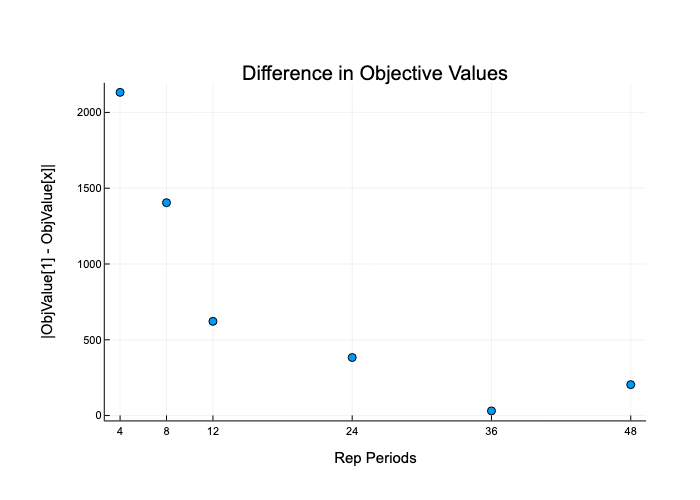

In [42]:
# Plot the differences as a function of number of representative periods
plotlyjs()
Plots.scatter(obj_val_plot[:,1],obj_val_plot[:,2],hover=obj_val_plot[:,2],legend=false,xticks=obj_val_plot[:,1],
                ylabel="|ObjValue[1] - ObjValue[x]|",xlabel="Rep Periods",title="Difference in Objective Values")

Here, we can see that while having very few representative periods produces an objective value that differs greatly from the orignal, once we reach around 12 representative periods the difference begins to taper out. Therefore, the original choice of 11 maximum periods in `SmallNewEngland/OneZone` decreases the run time of GenX significantly while while maintaining an objective value close to the original.


In [43]:
time_domain_reduction_settings["MinPeriods"] = 8;
time_domain_reduction_settings["MaxPeriods"] = 11;

In [44]:
YAML.write_file("Example_Systems_Tutorials/SmallNewEngland/OneZone/Settings/time_domain_reduction_settings.yml", time_domain_reduction_settings)